In [1]:
import os
os.getcwd()

'/home/zhaoming/Qin_Liu'

In [2]:
os.chdir('./A2C')

In [3]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
from Model import Actor, Critic
from VecEnv import EIEnv
env=EIEnv(gamma=0.95)
actor_net = Actor(env.observation_space.shape[0],16)
critic_net = Critic(env.observation_space.shape[0],17)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_net = actor_net.to(device)
critic_net = critic_net.to(device)
checkpoint = torch.load('./models/best')
actor_net.load_state_dict(checkpoint['actor_model_state_dict'],strict=False)
critic_net.load_state_dict(checkpoint['critic_model_state_dict'],strict=False)
actor_net.eval()
critic_net.eval()

OSError: libcudnn.so.8: cannot open shared object file: No such file or directory

In [6]:
import torch.distributions as dist
import numpy as np
gamma=0.95
np.random.seed(1)
steps=np.zeros([1439,20])
T_A2C = np.zeros([1439,10])
PAC_A2C = np.zeros([1439])
PEV_A2C = np.zeros([1439])
costs_all = []
actions = np.zeros([1439,16])

with torch.no_grad():
    observation = env.reset()
    for step in range(int(1439)):
        observation_in=env.observation_scalar(observation)
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        mu, sigma = actor_net(observation_in)
        values = critic_net(observation_in)
        normal_probs = dist.normal.Normal(mu,sigma+1e-1)
        action = normal_probs.sample()      
        action = action.detach().cpu().numpy()[0]
        # gather env data, reset done envs and update their obs
        observation, costs, _, _= env.step(action)
        T_A2C[step] = env.T_in
        steps[step]=observation
        PAC_A2C[step] = np.sum(env.P_AC)
        PEV_A2C[step] = np.sum(env.P_EV)
        actions[step]=action
        costs_all.append(costs)

In [7]:
os.chdir('../DDPG')

In [8]:
import sys
import numpy as np
import argparse
from copy import deepcopy
import torch
from env import EIEnv
from evaluator import Evaluator
from ddpg import DDPG
from util import *
parser = argparse.ArgumentParser(description='PyTorch on TORCS with Multi-modal')
parser.add_argument('--mode', default='train', type=str, help='support option: train/test')
parser.add_argument('--env', default='microgrid', type=str, help='')
parser.add_argument('--pre_training', default= True, type=bool, help='')
parser.add_argument('--rate', default=1e-3, type=float, help='learning rate')
parser.add_argument('--prate', default=2e-4, type=float, help='policy net learning rate (only for DDPG)')
parser.add_argument('--warmup', default=4*24*5, type=int, help='time without training but only filling the replay memory')
parser.add_argument('--discount', default=0.95, type=float, help='')
parser.add_argument('--bsize', default=64, type=int, help='minibatch size')
parser.add_argument('--rmsize', default=600000, type=int, help='memory size')
parser.add_argument('--window_length', default=1, type=int, help='')
parser.add_argument('--tau', default=0.001, type=float, help='moving average for target network')
parser.add_argument('--ou_theta', default=0.15, type=float, help='noise theta')
parser.add_argument('--ou_sigma', default=0.3, type=float, help='noise sigma') 
parser.add_argument('--ou_mu', default=0.0, type=float, help='noise mu') 
parser.add_argument('--validate_episodes', default=10, type=int, help='how many episode to perform during validate experiment')
parser.add_argument('--episodes_update_interval', default=10, type=int, help='how many episodes to update network')
parser.add_argument('--episodes_validate_interval', default=100, type=int, help='how many train episodes to perform a validate experiment')
parser.add_argument('--output', default='output', type=str, help='')
parser.add_argument('--debug', dest='debug', action='store_true')
parser.add_argument('--init_w', default=0.003, type=float, help='') 
parser.add_argument('--train_iter', default=3e8, type=int, help='train iters each timestep')
parser.add_argument('--epsilon', default=50000, type=int, help='linear decay of exploration policy')
parser.add_argument('--seed', default=-1, type=int, help='')
parser.add_argument('--cuda', default=True, type=bool, help='')
parser.add_argument('--resume', default='default', type=str, help='Resuming model path for testing')
args, unknown = parser.parse_known_args()
import torch
from env import EIEnv
from ddpg import DDPG
env = EIEnv()
nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
agent = DDPG(nb_states, nb_actions, device, args)
agent.load_best_weights('./output')
agent.is_training = False
agent.eval()
policy = lambda x: agent.select_action(x, decay_epsilon=False)
%config InlineBackend.figure_format='svg'
%matplotlib inline

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
episode_steps = 0
costs = np.zeros([1439,17])
obs = np.zeros([1439,20])
T_DDPG = np.zeros([1439,10])
E_EV = np.zeros([1439,5])
actions = np.zeros([1439,16])
PAC_DDPG = np.zeros([1439])
PEV_DDPG = np.zeros([1439])
#print(observation)
np.random.seed(1)
observation = env.reset()
assert observation is not None
# start episode
done = False
while not done:
    # basic operation, action ,reward, blablabla ...
    action = policy(observation)
    actions[episode_steps] = action
    observation, reward, done, info = env.step(action)
    obs[episode_steps]= observation
    T_DDPG[episode_steps]=env.T_in
    costs[episode_steps]=reward
    E_EV[episode_steps]=env.E_EV
    PAC_DDPG[episode_steps] = np.sum(env.P_AC)
    PEV_DDPG[episode_steps] = np.sum(env.P_EV)
    episode_steps += 1

In [10]:
os.chdir('..')

In [9]:
os.chdir('./DDPG')

In [10]:
#import imp
#imp.reload(env_no_control.EIEnv)
from env_no_control import EIEnv
env_no_control = EIEnv()
PAC_no_control = np.zeros(1439)
PEV_no_control = np.zeros(1439)
episode_steps = 0
np.random.seed(1)
observation = env_no_control.reset()
# start episode
done = False
while not done:
    # basic operation, action ,reward, blablabla ...
    observation, reward, done, info = env_no_control.step()
    PAC_no_control[episode_steps] = np.sum(env_no_control.P_AC)
    PEV_no_control[episode_steps] = np.sum(env_no_control.P_EV)
    episode_steps += 1

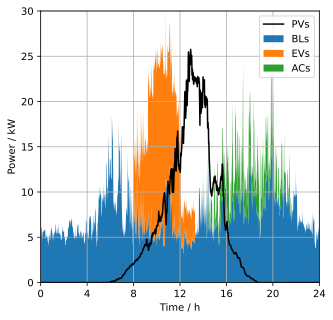

In [11]:
fig, (ax3) = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

ax3.plot(steps[:,0],  env.PV[:-1],'k', label='PVs')
ax3.fill_between(steps[:,0], env.load[:-1], label='BLs')
ax3.fill_between(steps[:,0], env.load[:-1], env.load[:-1]+PEV_no_control, label='EVs')
ax3.fill_between(steps[:,0],env.load[:-1]+PEV_no_control, env.load[:-1]+PEV_no_control+PAC_no_control, label='ACs')
ax3.set_xlim(0,24)
ax3.set_ylim(0,30)
ax3.set_xticks(np.linspace(0,24,7))
ax3.set_xlabel('Time / h')
ax3.set_ylabel('Power / kW')
ax3.grid()
ax3.legend()
#ax1.title.set_position([0.5, -0.2])
#ax1.set_title('(a) A2C')

#ax2.title.set_position([0.5, -0.2])
#ax2.set_title('(b) DDPG')
#fig.savefig(fname='./figure/loads.svg',format='svg',bbox_inches = 'tight',pad_inches = 0)
fig.show()

In [48]:
#generation cost
print(np.sum(A2C_costs[:,0]))
print(np.sum(costs[:,0]))

541.3767796073244
686.6841527073401


In [52]:
#BES cost
print(np.sum(A2C_costs[:,1]))
print(np.sum(costs[:,1]))

521.9268318228578
156.2858235211227


In [53]:
#EV
print(np.sum(A2C_costs[:,2:7]))
print(np.sum(costs[:,2:7]))

12.016051241744224
372.2819951065122


In [54]:
#AC
print(np.sum(A2C_costs[:,7:]))
print(np.sum(costs[:,7:]))

692.9302995940086
2386.1846570403527


In [49]:
#total cost
print(np.sum(A2C_costs))
print(np.sum(costs))

1768.249962265935
3601.4366283753275


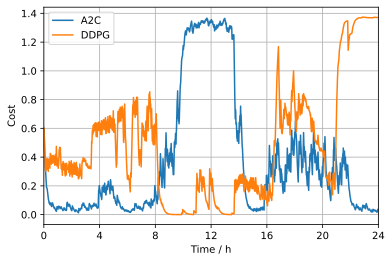

In [47]:
#obs: t[0], P_PV-PLsum[1], P_G[2], SOC[3], T_out[4] E_EV[5:5+M], AC_open_time[-N:]
A2C_costs = np.array(costs_all)
plt.plot(steps[:,0], A2C_costs[:,0], label='A2C')
plt.plot(steps[:,0], costs[:,0], label='DDPG')
plt.xlim(0,24)
#plt.ylim(-0.2,30)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Cost')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/cost.svg',format='svg')
plt.show()

In [16]:
os.chdir('..')

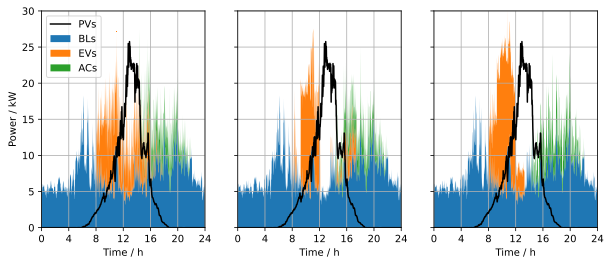

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 4))

ax1.plot(steps[:,0],  env.PV[:-1],'k', label='PVs')
ax1.fill_between(steps[:,0], env.load[:-1], label='BLs')
ax1.fill_between(steps[:,0], env.load[:-1], env.load[:-1]+PEV_A2C, label='EVs')
ax1.fill_between(steps[:,0],env.load[:-1]+PEV_A2C, env.load[:-1]+PEV_A2C+PAC_A2C, label='ACs')
ax1.set_xlim(0,24)
ax1.set_ylim(0,30)
ax1.set_xticks(np.linspace(0,24,7))
ax1.set_xlabel('Time / h')
ax1.set_ylabel('Power / kW')
ax1.grid()
ax1.legend(loc='upper left')
#ax1.title.set_position([0.5, -0.2])
#ax1.set_title('(a) A2C')

ax2.plot(steps[:,0],  env.PV[:-1],'k', label='PVs')
ax2.fill_between(steps[:,0], env.load[:-1], label='BLs')
ax2.fill_between(steps[:,0], env.load[:-1], env.load[:-1]+PEV_DDPG, label='EVs')
ax2.fill_between(steps[:,0],env.load[:-1]+PEV_DDPG, env.load[:-1]+PEV_DDPG+PAC_DDPG, label='ACs')
ax2.set_xlim(0,24)
#ax2.set_ylim(0,30)
ax2.set_xticks(np.linspace(0,24,7))
ax2.set_xlabel('Time / h')
#ax1.set_ylabel('Power / kW')
ax2.grid()
#ax2.legend()

ax3.plot(steps[:,0],  env.PV[:-1],'k', label='PVs')
ax3.fill_between(steps[:,0], env.load[:-1], label='BLs')
ax3.fill_between(steps[:,0], env.load[:-1], env.load[:-1]+PEV_no_control, label='EVs')
ax3.fill_between(steps[:,0],env.load[:-1]+PEV_no_control, env.load[:-1]+PEV_no_control+PAC_no_control, label='ACs')
ax3.set_xlim(0,24)
#ax3.set_ylim(0,30)
ax3.set_xticks(np.linspace(0,24,7))
ax3.set_xlabel('Time / h')
#ax3.set_ylabel('Power / kW')
ax3.grid()
#ax3.legend()

fig.savefig(fname='./figure/loads.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
fig.show()

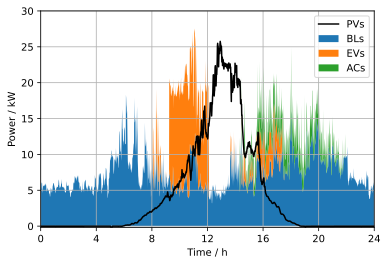

In [20]:
plt.plot(steps[:,0],  env.PV[:-1],'k', label='PVs')
plt.fill_between(steps[:,0], env.load[:-1], label='BLs')
plt.fill_between(steps[:,0], env.load[:-1], env.load[:-1]+PEV_DDPG, label='EVs')
plt.fill_between(steps[:,0],env.load[:-1]+PEV_DDPG, env.load[:-1]+PEV_DDPG+PAC_DDPG, label='ACs')
plt.xlim(0,24)
plt.ylim(-0.2,30)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
#plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

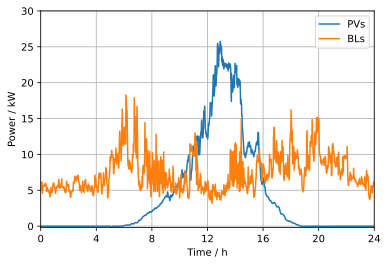

In [17]:
#obs: t[0], P_PV-PLsum[1], P_G[2], SOC[3], T_out[4] E_EV[5:5+M], AC_open_time[-N:]
plt.plot(steps[:,0], env.PV[:-2], label='PVs')
plt.plot(steps[:,0], env.load[:-2], label='BLs')
plt.xlim(0,24)
plt.ylim(-0.2,30)
plt.xticks(np.linspace(0,24,7))
plt.xlabel('Time / h')
plt.ylabel('Power / kW')
plt.grid()
plt.legend()
plt.savefig(fname='./figure/pv_load.svg',format='svg')
plt.show()

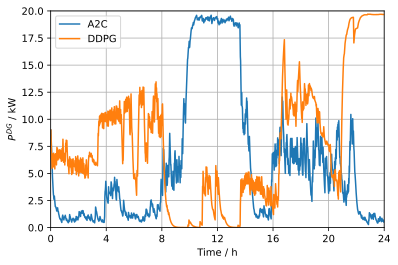

In [21]:
plt.plot(steps[:,0], steps[:,2], label='A2C')
plt.plot(obs[:,0], obs[:,2], label='DDPG')
plt.xlim(0,24)
plt.ylim(0,20)
plt.xlabel('Time / h')
plt.ylabel('$P^{DG}$ / kW')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
plt.savefig(fname='./figure/DG.svg',format='svg')
plt.show()

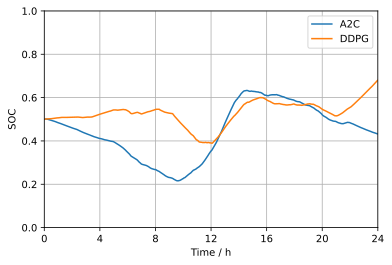

In [9]:
plt.plot(steps[:,0], steps[:,3], label='A2C')
plt.plot(obs[:,0], obs[:,3], label='DDPG')
plt.ylim(0,1)
plt.xlim(0,24)
plt.xlabel('Time / h')
plt.ylabel('SOC')
plt.xticks(np.linspace(0,24,7))
plt.grid()
plt.legend()
plt.savefig(fname='./figure/soc.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

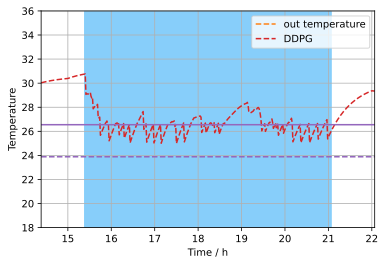

In [58]:
n=8
plt.plot(obs[:,0],obs[:,5], 'C1--', label='out temperature')
#plt.plot(steps[:,0],T_A2C[:,n], 'C2', label = 'A2C')
plt.plot(obs[:,0],T_DDPG[:,n], 'C3--', label = 'DDPG')
plt.plot(obs[:,0], env.Tupper[n]*np.ones(len(obs[:,0])), 'C4')
#plt.text(1, env.Tupper[n]+0.5, '$T_{max}$')
plt.plot(obs[:,0], env.Tlower[n]*np.ones(len(obs[:,0])),'C4--')
#plt.text(1, env.Tlower[n]-0.7, '$T_{min}$')
plt.fill_between(np.linspace(env.start_AC_time[n],env.end_AC_time[n],100),18*np.ones(100), 36*np.ones(100),color='lightskyblue')
plt.xlim(env.start_AC_time[n]-1,env.end_AC_time[n]+1)
plt.ylim(18,36)
#plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/Temperature.svg',format='svg')
plt.show()

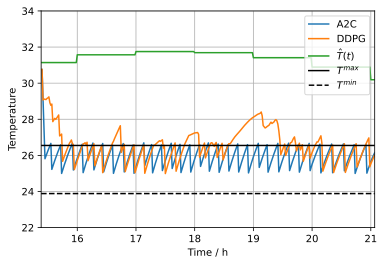

In [10]:
n=8
plt.plot(steps[:,0],T_A2C[:,n], 'C0', label = 'A2C')
plt.plot(obs[:,0],T_DDPG[:,n], 'C1', label = 'DDPG')
plt.plot(obs[:,0],obs[:,4], 'C2', label='$\hat{T}(t)$')
plt.plot(obs[:,0], env.Tupper[n]*np.ones(len(obs[:,0])), 'k',label='$T^{max}$')
plt.plot(obs[:,0], env.Tlower[n]*np.ones(len(obs[:,0])),'k--',label='$T^{min}$')
plt.xlim(env.start_AC_time[n],env.end_AC_time[n])
plt.ylim(22,34)
#plt.xticks(np.linspace(0,24,7))
plt.ylabel('Temperature')
plt.xlabel('Time / h')
plt.legend()
plt.grid()
plt.savefig(fname='./figure/Temperature.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

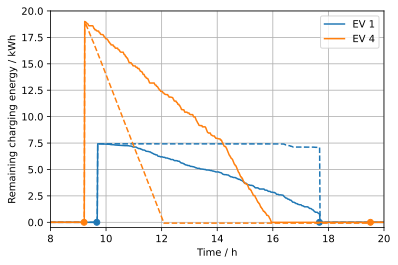

In [21]:
n1=1
n4=4
plt.plot(steps[:,0],steps[:,4+n1], 'C0', label='EV 1')
plt.plot(obs[:,0],obs[:,4+n1], 'C0--')
plt.plot(env.start_charge_time[n1-1],obs[0,4+n1],'C0o')
plt.plot(env.end_charge_time[n1-1],obs[-1,4+n1],'C0o')

plt.plot(steps[:,0],steps[:,4+n4], 'C1', label='EV 4')
plt.plot(obs[:,0],obs[:,4+n4], 'C1--')
plt.plot(env.start_charge_time[n4-1],obs[0,4+n4],'C1o')
plt.plot(env.end_charge_time[n4-1],obs[-1,4+n4],'C1o')

plt.xticks(np.linspace(8,20,7))
plt.xlim(8,20)
plt.ylim(-0.5,20)
plt.ylabel('Remaining charging energy / kWh')
plt.xlabel('Time / h')
plt.grid()
plt.legend()
plt.savefig(fname='./figure/EV.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [1]:
(3601.4-1768.2)/3601.4

0.50902426834009

In [2]:
12/372.3

0.032232070910556